In [1]:

import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import access_br_dwgd as access_br_dwgd
import sys, os
sys.path.append(os.path.abspath(".."))

import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="biLstmBrDwgd.log", nome_classe="BiLstm BrDwgd")
logger.info("Iniciando script de previsão com BiLSTM BrDwgd(TensorFlow/Keras).")

2025-10-01 22:44:07.896914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 22:44:11,394 - BiLstm BrDwgd - INFO - Iniciando script de previsão com BiLSTM BrDwgd(TensorFlow/Keras).


2025-10-01 22:44:14,179 - BiLstm BrDwgd - INFO - Dados carregados com sucesso. Total de 5924 registros.


[-22.98833275 -43.19055557  25.59000015]


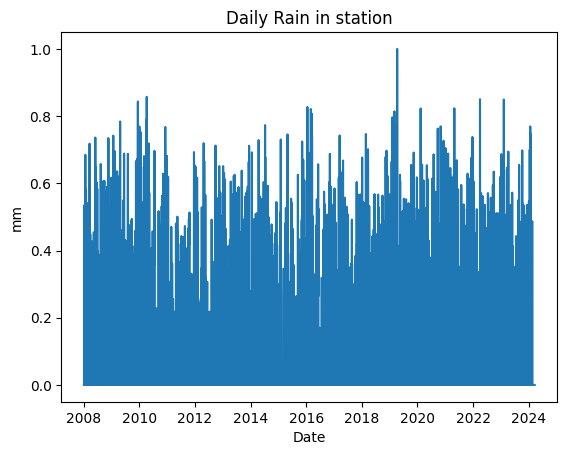

In [2]:
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(timeseries.values.reshape(-1, 1))
timeseries = pd.Series(df_scaled.flatten(), index=timeseries.index)
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 

plt.plot(timeseries)
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()


In [3]:
lookback = 30
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequence(timeseries, lookback)
dates_aligned = datas[lookback:]

train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


2025-10-01 22:44:14,332 - BiLstm BrDwgd - INFO - Preparando sequências com um lookback de 30 dias.
/home/pbose/tcc/pesquisa/utils/lstm.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+lookback])
2025-10-01 22:44:14,720 - BiLstm BrDwgd - INFO - Sequências criadas. Treino: 4125 amostras, Teste: 1769 amostras.


In [4]:
epochs = 700
batch_size = 64
# Building the model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))  

logger.info(f"Iniciando treinamento por {epochs} épocas. Com batch_size: {batch_size}")


model.compile(optimizer="adam", loss="mse")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
)
logger.info("Treinamento concluído.")

# --- Previsão ---
logger.info("Realizando previsões no conjunto de teste.")
pred = model.predict(X_test)
#pred_rescaled = scaler.inverse_transform(pred)
#real_rescaled = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

2025-10-01 22:44:14.734059: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pbose/tcc/pesquisa/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-10-01 22:44:14,834 - BiLstm BrDwgd - INFO - Iniciando treinamento por 700 épocas. Com batch_size: 64


Epoch 1/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0309 - val_loss: 0.0314
Epoch 2/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0295 - val_loss: 0.0307
Epoch 3/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0295 - val_loss: 0.0306
Epoch 4/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0290 - val_loss: 0.0304
Epoch 5/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0286 - val_loss: 0.0301
Epoch 6/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0285 - val_loss: 0.0298
Epoch 7/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0284 - val_loss: 0.0297
Epoch 8/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0282 - val_loss: 0.0301
Epoch 9/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0285 - val_loss: 0.0300
Epoch 10/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0282 - val_loss: 0.0298
Epoch 11/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0284 - val_loss: 0.0298
Epoch 12/700
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

2025-10-01 23:15:40,954 - BiLstm BrDwgd - INFO - Treinamento concluído.
2025-10-01 23:15:40,955 - BiLstm BrDwgd - INFO - Realizando previsões no conjunto de teste.


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


2025-10-01 23:15:41,923 - BiLstm BrDwgd - INFO - Avaliação do Modelo - RMSE: 0.1979, MSE: 0.0391, MAE: 0.1348


2025-10-01 23:15:41,930 - BiLstm BrDwgd - INFO - Gerando gráfico de previsão final.


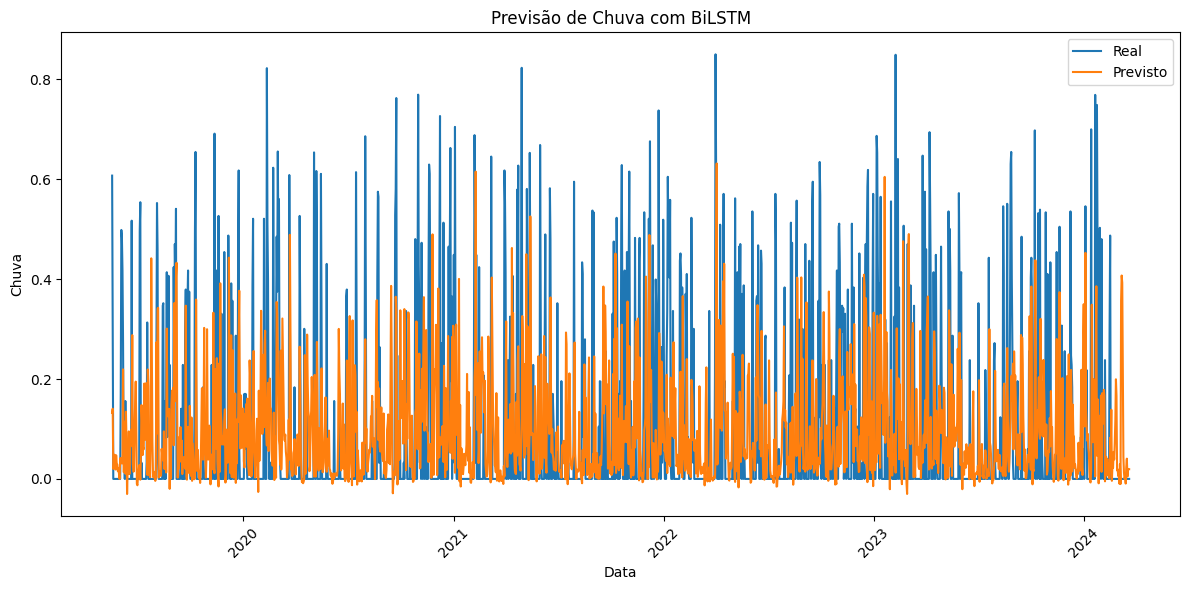

2025-10-01 23:15:42,097 - BiLstm BrDwgd - INFO - Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.


In [5]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.")